In [1]:
# import torch
# from torch_geometric.data import Data

# edge_index = torch.tensor([[0, 1, 1, 2],
#                            [1, 0, 2, 1]], dtype=torch.long)
# x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# data = Data(x=x, edge_index=edge_index)
# data

In [3]:
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
indices = labels.index("Om"), labels.index("s8")

In [4]:
import sys
sys.path.append("../scripts/")
from peaks_pygdata import Patches

dataset_name = "20231107_patches_flatsky_fwhm3_radius8_noiseless"

dataset = Patches(dataset_name)

In [15]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[:int(len(dataset) * 0.001)]
test_dataset = dataset[int(len(dataset) * 0.9999):]

print(len(train_dataset), len(test_dataset))
batch_size = 2 ** 5
print(batch_size, len(train_dataset) / batch_size)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

169 17
32 5.28125


In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
true = np.array([])
for i, data in enumerate(train_dataloader):
    true = np.append(true, data.y.numpy())

true = true.reshape(-1, 6)[:,indices]
print(true.shape)

scaler = scaler.fit(true)

(169, 2)


In [28]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [29]:
import tqdm, gc

model = GCN(hidden_channels=64)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

def train(loader):
    model.train()
    train_loss = 0
    for data in tqdm.tqdm(loader):  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        true = torch.tensor(scaler.transform(data.y.reshape(-1, 6)[:,indices]), dtype=torch.float32)
        loss = criterion(out, true)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_loss += loss.detach().item()
        del data, out, loss, true
        gc.collect()
    return train_loss / len(train_dataset)

def test(loader):
    model.eval()
    mse = 0
    for data in tqdm.tqdm(loader):  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        true = torch.tensor(scaler.transform(data.y.reshape(-1, 6)[:,indices]), dtype=torch.float32)
        mse += torch.sum((out - true) ** 2).item()
        del data, out, true
        gc.collect()
    return mse / len(test_dataset)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
num_epochs = 10

for epoch in range(num_epochs):
    train_mse = train(train_dataloader)
    test_mse = test(test_dataloader)
    print(f"Epoch: {epoch}, Train MSE: {train_mse}, Test MSE: {test_mse}", flush=True)

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Epoch: 0, Train MSE: 0.012920755231697884, Test MSE: 0.6361580518995695



100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

Epoch: 1, Train MSE: 0.007361204225636093, Test MSE: 0.160430774778385



100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch: 2, Train MSE: 0.003880331171511193, Test MSE: 0.36341047781514024



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Epoch: 3, Train MSE: 0.0036176210985733913, Test MSE: 0.18526161104483027



100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

Epoch: 4, Train MSE: 0.0027699075286557687, Test MSE: 0.16181670865242168



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

Epoch: 5, Train MSE: 0.002340879181080316, Test MSE: 0.1931672504743154



100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

Epoch: 6, Train MSE: 0.002088665653615308, Test MSE: 0.155628893064437



100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch: 7, Train MSE: 0.0021037037467815465, Test MSE: 0.15634474348397365



100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

Epoch: 8, Train MSE: 0.002077007919726287, Test MSE: 0.1537006082166878



100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

Epoch: 9, Train MSE: 0.0019413745526731367, Test MSE: 0.15913449474005334


In [37]:
# plot predictions vs true values
import matplotlib.pyplot as plt
import numpy as np

out, true = np.array([]), np.array([])
loader = train_dataloader

model.eval()
for data in loader:
    out = np.append(out, scaler.inverse_transform(model(data.x, data.edge_index, data.batch).detach().numpy()))
    true = np.append(true, data.y.detach().numpy())
    del data
    gc.collect()
    break

out = out.reshape(-1, 2)
true = true.reshape(-1, 6)[:, indices]
print(out.shape, true.shape)

(32, 2) (32, 2)


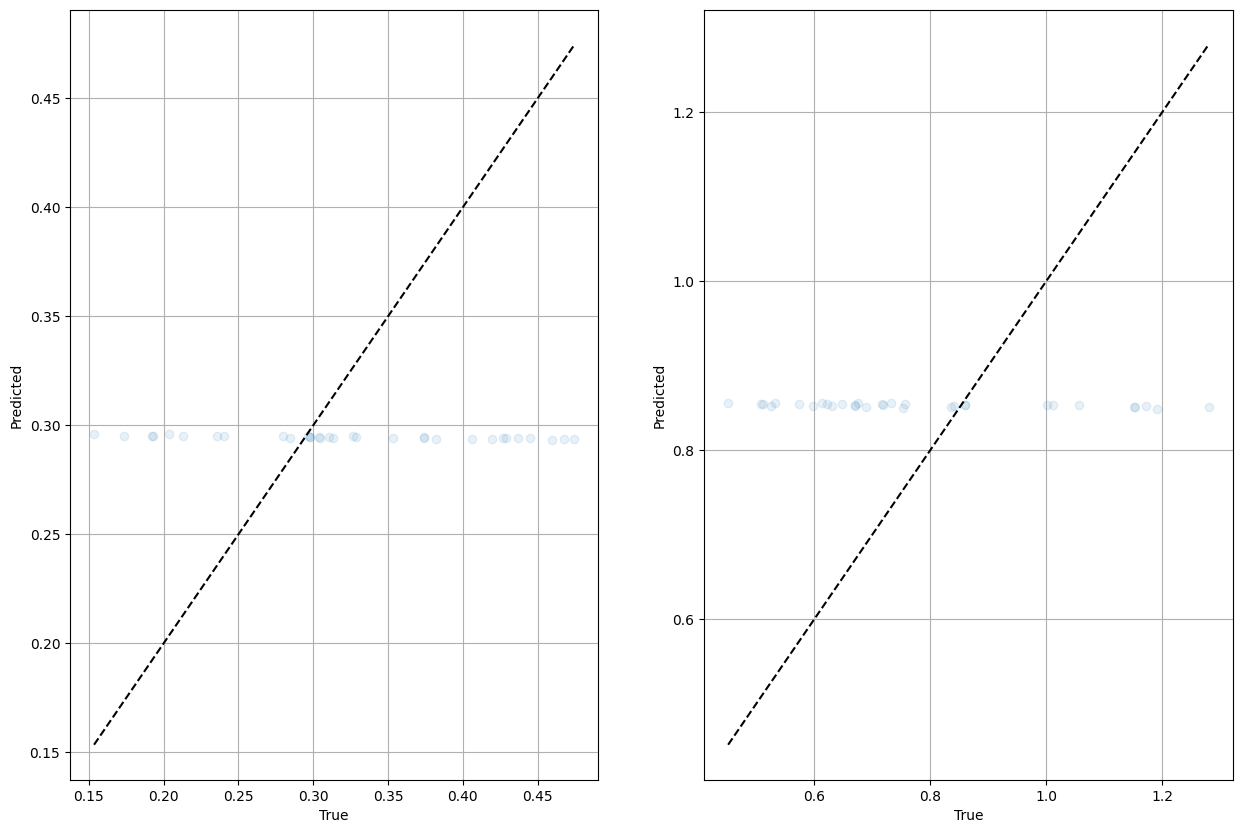

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
for ind, ax in enumerate(axs.flatten()):
    ax.plot(true[:, ind], out[:, ind], "o", alpha=0.1)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid()
    ax.plot([np.min(true[:, ind]), np.max(true[:, ind])], \
            [np.min(true[:, ind]), np.max(true[:, ind])], "k--")
plt.show()
plt.close()

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from torch_geometric.nn import GCN
model = GCN(in_channels=-1, hidden_channels=64, out_channels=len(dataset[0].y), \
            num_layers=3).to(device)
print(model)

cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()

    mse = 0
    for data in loader:
        data = data.to(device)
        out = model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        # mse error
        mse += torch.sum((out - data.y) ** 2).item()
    return mse / len(test_dataset)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    train()
    train_mse = test(train_dataloader)
    test_mse = test(test_dataloader)
    print(f"Epoch: {epoch}, Train MSE: {train_mse}, Test MSE: {test_mse}")

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43735,0,0], thread: [32,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [76,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [27,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [42,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [58,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: ope

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
